In [1]:
import numpy as np
from ptsa.data.filters import ResampleFilter, ButterworthFilter, MorletWaveletFilter
import cmlreaders as cml
from ptsa.data.timeseries import TimeSeries
import h5py
import os
import sys
import pandas as pd
import scipy as sp
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
import cc_utils as cc

from scipy import fft
from scipy.stats import linregress,siegelslopes,theilslopes

In [12]:
# sys.path.append('/home1/john/johnModules')
# sys.path.append('/home1/john/RSA/code')

# rhino_mount = ''

exp = 'RepFR1' # catFR1 # # **select experiment here**
period = 'encoding' # 'retrieval' 'encoding'
POWHZ = 50. # downsampling factor
FREQS = np.logspace(np.log10(3),np.log10(180), 8)

select_subs = 1
test_subjects = ['R1584J'] # **select subject here**

df = cml.CMLReader.get_data_index()

if select_subs == 1:
    exp_df = df.query('experiment == @exp and subject == @test_subjects')
# exp_df = exp_df[4:5] # **select session here**
    
print('Number of sessions: '+str(len(exp_df)))
print('Number of subjects: '+str(len(np.unique(exp_df.subject))))
exp_df

Number of sessions: 6
Number of subjects: 1


Recognition all_events  \
2561         NaN        NaN   
2562         NaN        NaN   
2563         NaN        NaN   
2564         NaN        NaN   
2565         NaN        NaN   
2566         NaN        NaN   

                                               contacts experiment  \
2561  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   
2562  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   
2563  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   
2564  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   
2565  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   
2566  protocols/r1/subjects/R1584J/localizations/0/m...     RepFR1   

     import_type  localization math_events  montage original_experiment  \
2561       build             0         NaN        0                 NaN   
2562       build             0         NaN        0                 NaN   
2563       build             0         NaN        0                 NaN   
2564       build             0         NaN        0                 NaN   
2565       build             0         NaN        0                 NaN   
2566       build             0         NaN        0                 NaN   

     original_session                                              pairs  \
2561              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   
2562              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   
2563              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   
2564              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   
2565              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   
2566              NaN  protocols/r1/subjects/R1584J/localizations/0/m...   

     ps4_events  session subject subject_alias  system_version  \
2561        NaN        0  R1584J        R1584J             4.0   
2562        NaN        1  R1584J        R1584J             4.0   
2563        NaN        2  R1584J        R1584J             4.0   
2564        NaN        3  R1584J        R1584J             4.0   
2565        NaN        4  R1584J        R1584J             4.0   
2566        NaN        5  R1584J        R1584J             4.0   

                                            task_events  
2561  protocols/r1/subjects/R1584J/experiments/RepFR...  
2562  protocols/r1/subjects/R1584J/experiments/RepFR...  
2563  protocols/r1/subjects/R1584J/experiments/RepFR...  
2564  protocols/r1/subjects/R1584J/experiments/RepFR...  
2565  protocols/r1/subjects/R1584J/experiments/RepFR...  
2566  protocols/r1/subjects/R1584J/experiments/RepFR...

# Load EEG and run Morlet

In [ ]:
save_values = 0

pow_params = {
    'catFR1': {
        'encoding': {
            'output_path': ('hdf5_files_sess/encoding/'),
            'mirror': False,
            'start_time': -0.5,
            'end_time': 2.1,
            'buf': 1.0,
            # 'evfilt': ev['type']=='WORD'
            'ev_type': ['WORD']
        },
        'retrieval': {
             'output_path': ('hdf5_files_sess/retrieval/'),
            'mirror': True,
            'start_time': -0.9,
            'end_time': -0.1,
            'buf': 0.76,
            # 'evfilt': ((ev['type']=='REC_WORD') |
            #            (ev['type']=='REC_BASE'))
            'ev_type': ['REC_WORD', 'REC_BASE']
        },
        'countdown': {
            'output_path': ('hdf5_files_sess/encoding/'),
            'mirror': False,
            'start_time': 1,
            'end_time': 2,
            'buf': 1,
            'ev_type': ['COUNTDOWN_START']
        }        
    },
    'RepFR1': {
        'encoding': {
            'mirror': False,
            'start_time': 0.3,
            'end_time': 1.3,
            'buf': 2.0, # 1.0
            'ev_type': ['WORD']
        },
        'retrieval': {
            'mirror': True,
            'start_time': -0.9,
            'end_time': -0.1,
            'buf': 0.76,
            'ev_type': ['REC_WORD', 'REC_BASE']
        },
        'countdown': {
            'mirror': False,
            'start_time': 1,
            'end_time': 2,
            'buf': 1,
            'ev_type': ['COUNTDOWN']
        }           
    },
}

# catFR_test_subs = ['R1354E', 'R1361C']
# exp_ix = exp_ix.query('subject == @catFR_test_subs')
scratch_dir = '/scratch/john/repFR_RSA/'

for _, df_sess in exp_df.iterrows():
    raw_fp = scratch_dir + 'preproc_data/' + period + '/' + df_sess['subject'] + '_' + str(df_sess['session'])
    h5_fp = raw_fp + '.h5'
#     if os.path.exists(h5_fp):
#         print(h5_fp + 'exists')
#         continue
#     try:
#     print(df_sess['subject']+', session '+str(df_sess['session']))
    reader = cml.CMLReader(subject=df_sess['subject'], 
                           experiment=df_sess['experiment'], session=df_sess['session'],
                           localization=df_sess['localization'], montage=df_sess['montage'])
    events = reader.load('task_events')
    ev_type = pow_params[exp][period]['ev_type']
    events = events.query('type == @ev_type')
    if period == 'encoding':
        events = cc.process_events(events)
    elif period == 'retrieval':
        events = cc.process_events_retrieval(events) 
    elif period == 'countdown':
        events = cc.process_events_countdown(events) 

    scheme = reader.load("pairs")
    buf = pow_params[exp][period]['buf'] * 1000
    rel_start = pow_params[exp][period]['start_time'] * 1000
    rel_stop = pow_params[exp][period]['end_time'] * 1000

    if pow_params[exp][period]['mirror']: # use mirror for retrieval for unknown reasons
        dat = reader.load_eeg(events=events,
                          rel_start=rel_start,
                          rel_stop=rel_stop,
                          scheme=scheme).to_ptsa()
        dat['time'] = dat['time'] / 1000 # using PTSA time scale
        dat = dat.add_mirror_buffer(pow_params[exp][period]['buf'])
        dat['time'] = dat['time'] * 1000
    else:
        dat = reader.load_eeg(events=events,
                          rel_start=-buf+rel_start,
                          rel_stop=buf+rel_stop,
                          scheme=scheme).to_ptsa()


    dat = dat.astype(float) - dat.mean('time')

    #         dat = dat[:,:,0:2,:] # for debugging just grab a few channels




### Can comment out this block to just run first cell below

    # do each step twice with split channels
    half_elec = int(np.shape(dat)[1]/2)

    # Notch Butterworth filter for 60Hz line noise:
    dat1 = ButterworthFilter(freq_range=[58, 62], filt_type='stop', order=4).filter(timeseries=dat[:,:half_elec,:])
    dat2 = ButterworthFilter(freq_range=[58, 62], filt_type='stop', order=4).filter(timeseries=dat[:,half_elec:,:])

    dat1 = MorletWaveletFilter(freqs=FREQS, output='power',width=5, verbose=True).filter(timeseries=dat1)
    dat2 = MorletWaveletFilter(freqs=FREQS, output='power',width=5, verbose=True).filter(timeseries=dat2)
#     print('done morlet')
    dat1 = xr.ufuncs.log10(dat1, out=dat1.values)
    dat2 = xr.ufuncs.log10(dat2, out=dat2.values)

    dat1 = ResampleFilter(resamplerate=POWHZ).filter(timeseries=dat1) # 8 x trials x elecs x 4594 resampled to 20 ms bins
    dat2 = ResampleFilter(resamplerate=POWHZ).filter(timeseries=dat2)
#     print('done resample')

    filter_noise_lines = 1

    if filter_noise_lines == 1:
        # line noise removal
        line_filt_dat = ButterworthFilter(freq_range=[58., 62.], filt_type='stop', order=4).filter(timeseries=dat)
        line_filt_dat = ButterworthFilter(freq_range=[118., 122.], filt_type='stop', order=4).filter(timeseries=line_filt_dat)        
        line_filt_dat = ButterworthFilter(freq_range=[178., 182.], filt_type='stop', order=4).filter(timeseries=line_filt_dat)                
    else:
        line_filt_dat = dat     
#     print('Shape of line_filt_dat:')
#     print(np.shape(line_filt_dat))
    sr = dat.samplerate.values
#     print(sr)


    # re-append channels and clear previous variables

    dat = dat1.append(dat2,'channel') 
    dat1 = None; dat2 = None

    dat = dat.remove_buffer(duration=(buf / 1000))

    dat = dat.mean('time') # average over time so 8 x trials x elecs

    if (period == 'encoding') | (period == 'countdown'):
        z_pow_all = xr.apply_ufunc(sp.stats.zscore, dat, 
                                   input_core_dims=[['channel', 'frequency']], 
                                   output_core_dims=[['channel', 'frequency']]) # outputs trials x elecs x 8
    elif period == 'retrieval':
        z_pow_all = xr.apply_ufunc(sp.stats.zscore, dat, 
                                   input_core_dims=[['channel', 'frequency', 'time']], 
                                   output_core_dims=[['channel', 'frequency', 'time']])
    z_pow_stacked = z_pow_all.stack(cf=("channel", "frequency")) # trials x 8*elecs

    z_pow_stacked = z_pow_stacked.assign_coords({"event" : z_pow_stacked.indexes['event']}) #.droplevel('stim_params')})

    if save_values == 1:
        TimeSeries(z_pow_stacked, coords=z_pow_stacked.coords).to_hdf(h5_fp)

###

#     print('Done with everything!')

#     except:
#         print("Unexpected error:", sys.exc_info())
#         exc_type, exc_obj, exc_tb = sys.exc_info()
#         print(os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]+'; line: '+str(exc_tb.tb_lineno))
#         continue

CPP total time wavelet loop:  25.04081392288208
CPP total time wavelet loop:  24.678446531295776


/usr/global/Anaconda/2019-10/lib/python3.7/site-packages/ipykernel_launcher.py:122: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
/home1/radrogue/.conda/envs/environmentname/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/usr/global/Anaconda/2019-10/lib/python3.7/site-packages/ipykernel_launcher.py:123: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
/home1/radrogue/.conda/envs/environmentname/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


CPP total time wavelet loop:  16.5148286819458
CPP total time wavelet loop:  16.364463090896606


/usr/global/Anaconda/2019-10/lib/python3.7/site-packages/ipykernel_launcher.py:122: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
/home1/radrogue/.conda/envs/environmentname/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


# Plot single trial/channel FFTs and raw trace

In [6]:
import warnings
    
N = 1000 #np.shape(line_filt_dat)[2] # Number of samplepoints 
T = 1.0 / N # sample spacing 
sr = line_filt_dat.samplerate.values

trial = 111
channel = 78

time_range = range(0,int(2000*(sr/1000))) # 2000 ms 
plot_range = range(5,382) # first few are strange...then only go to 200 Hz (which is 400)
shift_factor = 1 # taking different time chunks shifts the frequencies

y = line_filt_dat[trial,channel,time_range]

# Make good/bad electrode plots

In [7]:
# get R^2, absolute residualss, correlations of spectral features for plots below

# run "plot single trial" cell above first to load the setup constants

ch_r2 = []
ch_resid = []
ch_sq = []
ch_z_pow = []
ch_std = []
ch_kurt = []
ch_raw_kurt = []
for ch in range(np.shape(line_filt_dat)[1]):
    abs_resid = []
    sq_dists = [] 
    r2 = []
    z_pows = []
    temp_std = []
    temp_kurt = []
    for tr in range(np.shape(line_filt_dat)[0]):

        y = line_filt_dat[tr,ch,time_range]

        yf = fft(y) 
        # get the frequency spectrum after the fft by removing mirrored signal and taking modulus
        corrected_yf = shift_factor/N * np.abs(yf[:N//2]) 
        xf = np.linspace(0.0, N/2, N)    
        xplot = xf[plot_range]
        yplot = corrected_yf[plot_range]

        slope, intercept, r_value, _, _ = linregress(np.log(xplot), np.log(yplot))
        r2.append(r_value**2) # same as np.corrcoef^2 for linear regression
        spectrum_val = np.polyval([slope,intercept],np.log(xplot))
        abs_resid.append(np.mean(np.abs([np.exp(n) for n in spectrum_val]-np.log(yplot))))
        sq_dists.append(np.mean(np.square(abs_resid)))
        temp_std.append(np.std(y))
        temp_kurt.append(sp.stats.kurtosis(y))
        if tr < np.shape(line_filt_dat)[0]-1: # last one don't look for correlation
            z_pows.append(np.corrcoef(z_pow_all[tr,ch,:],z_pow_all[tr+1,ch,:])[0,1])
            
        # z_pows.append(sum(np.abs(z_pow_all[tr,ch,:].values))) # absolute sum of z-scored spectral powers
        
    ch_r2.append(np.mean(r2))
    ch_resid.append(np.mean(abs_resid))
    ch_sq.append(np.mean(sq_dists))
    ch_z_pow.append(np.mean(z_pows))
    ch_std.append(np.mean(temp_std))
    ch_kurt.append(sp.stats.kurtosis(abs_resid))
    ch_raw_kurt.append(np.mean(temp_kurt))
#     if ch == int(np.median(range(np.shape(line_filt_dat)[1]))):
#         print('Halfway there buddy!')
# print('Done getting ur measurements')

Halfway there buddy!
Done getting ur measurements


# Scatterplots of channels to identify weird ones

R1584J, session 4 (RepFR1)


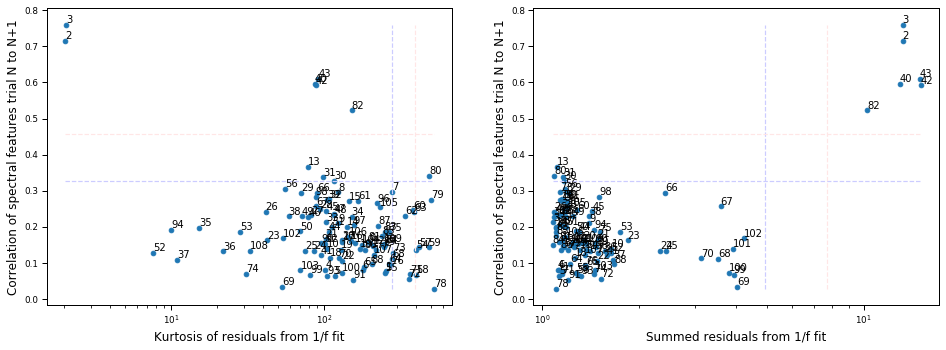

In [11]:
import seaborn as sb
sb.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12,
                            "axes.ticksize":12,"axes.titlesize":12})
from adjustText import adjust_text
import time; t = time.time()

def scatterWithFirstSecondStds(ax,data1,data2,improve_labels = False):
    ax.scatter(data1, data2)
    texts = [plt.text(data1[i], data2[i],txt,ha='left', va='bottom') for i, txt in enumerate(range(len(data1)))]
#     if improve_labels == True:
#         adjust_text(texts) # this is cool but it takes dozens of seconds
    ax.vlines(np.mean(data1)+np.std(data1),np.min(data2),np.max(data2),color=(0.8,0.8,1),linestyle='--') # 1 std
    ax.hlines(np.mean(data2)+np.std(data2),np.min(data1),np.max(data1),color=(0.8,0.8,1),linestyle='--') # 1 std
    ax.vlines(np.mean(data1)+2*np.std(data1),np.min(data2),np.max(data2),color=(1,0.9,0.9),linestyle='--') # 2 std
    ax.hlines(np.mean(data2)+2*np.std(data2),np.min(data1),np.max(data1),color=(1,0.9,0.9),linestyle='--') # 2 std
    return ax,texts

print(df_sess['subject']+', session '+str(df_sess['session'])+' ('+exp+')')
plt.subplots(1,1,figsize=(16,12))

# set data that will give NaNs to low value
temp_ch_z_pow = np.array(ch_z_pow); temp_ch_kurt = np.array(ch_kurt)
temp_ch_z_pow[temp_ch_z_pow<=0] = 0.01
temp_ch_kurt[temp_ch_kurt<=0] = 0.01

# 1) plot R^2 of fit v. absolute sum of z_scored spectral pows
ax = plt.subplot(2,2,1)
ax,texts = scatterWithFirstSecondStds(ax,temp_ch_kurt, temp_ch_z_pow)
plt.xlabel('Kurtosis of residuals from 1/f fit')
plt.ylabel('Correlation of spectral features trial N to N+1')
ax.set_xscale('log')

# 2) plot R^2 of fit v. absolute sum of z_scored spectral pows
ax = plt.subplot(2,2,2)
ax,texts = scatterWithFirstSecondStds(ax,ch_resid, ch_z_pow)
plt.xlabel('Summed residuals from 1/f fit')
plt.ylabel('Correlation of spectral features trial N to N+1')
ax.set_xscale('log')


In [ ]:
print(df_sess['subject']+', session '+str(df_sess['session'])+' ('+exp+')')
plt.subplots(1,2,figsize=(16,6))

temp_ch_kurt = np.array(copy(ch_raw_kurt))
temp_ch_kurt[temp_ch_kurt<=0] = 0.01

# # plot R^2 of fit v. summed diffs to fit # R^2 never worked very well
# ax = plt.subplot(1,2,1)
# ax,texts = scatterWithFirstSecondStds(ax,ch_r2,ch_resid) # improving labels is cool but takes dozens of seconds to run
# plt.xlabel('R^2 of 1/f fit')
# plt.ylabel('Summed residuals from 1/f fit')
# ax.set_yscale('log')

# Correlation of spectral features v. Kurtosis of raw values
ax = plt.subplot(1,2,1)
ax,texts = scatterWithFirstSecondStds(ax,temp_ch_kurt,ch_z_pow) # improving labels is cool but takes dozens of seconds to run
plt.xlabel('Kurtosis of raw values')
plt.ylabel('Correlation of spectral features trial N to N+1')
ax.set_xscale('log')

# Correlation v. std
ax = plt.subplot(1,2,2)
ax,texts = scatterWithFirstSecondStds(ax,ch_std, ch_z_pow)
plt.xlabel('Standard deviation of raw timeseries')
plt.ylabel('Correlation of spectral features trial N to N+1')
# ax.set_xscale('log')
plt.show()

a=1;

# Plot raw traces with spectrograms and PSDs underneath

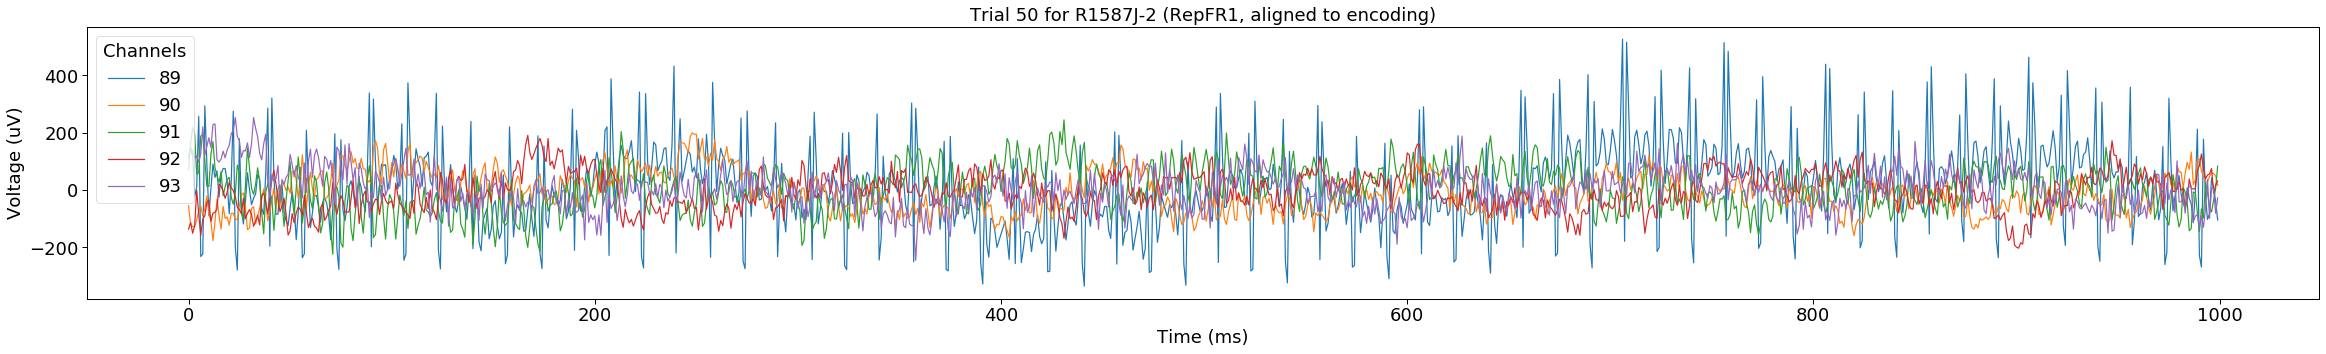

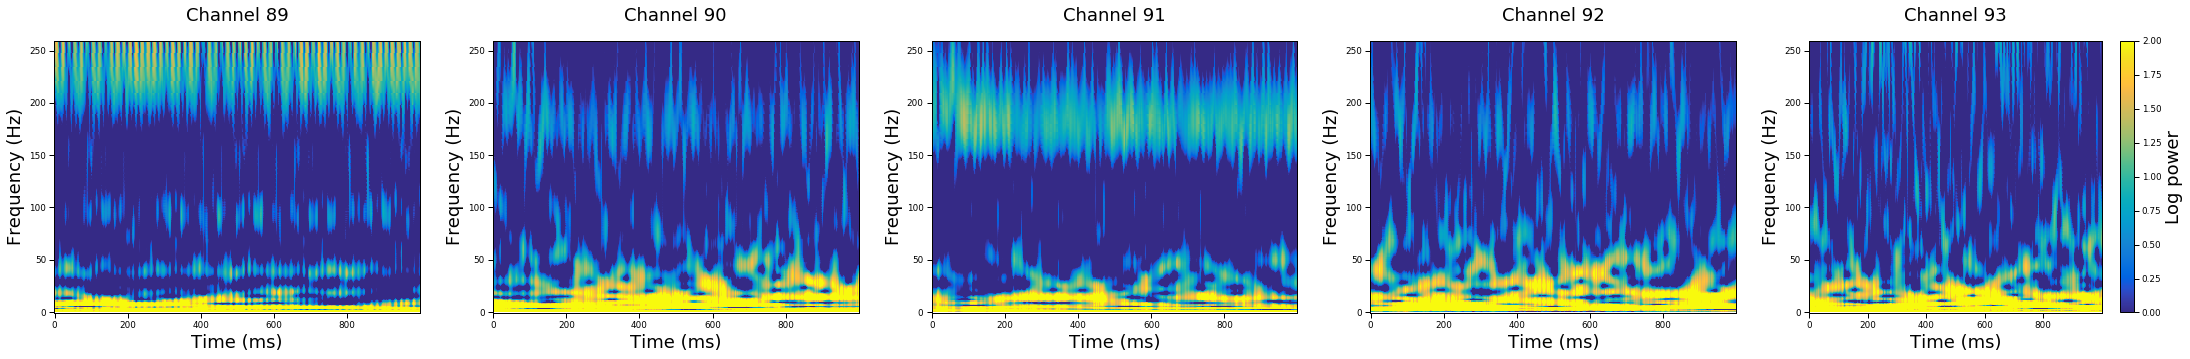

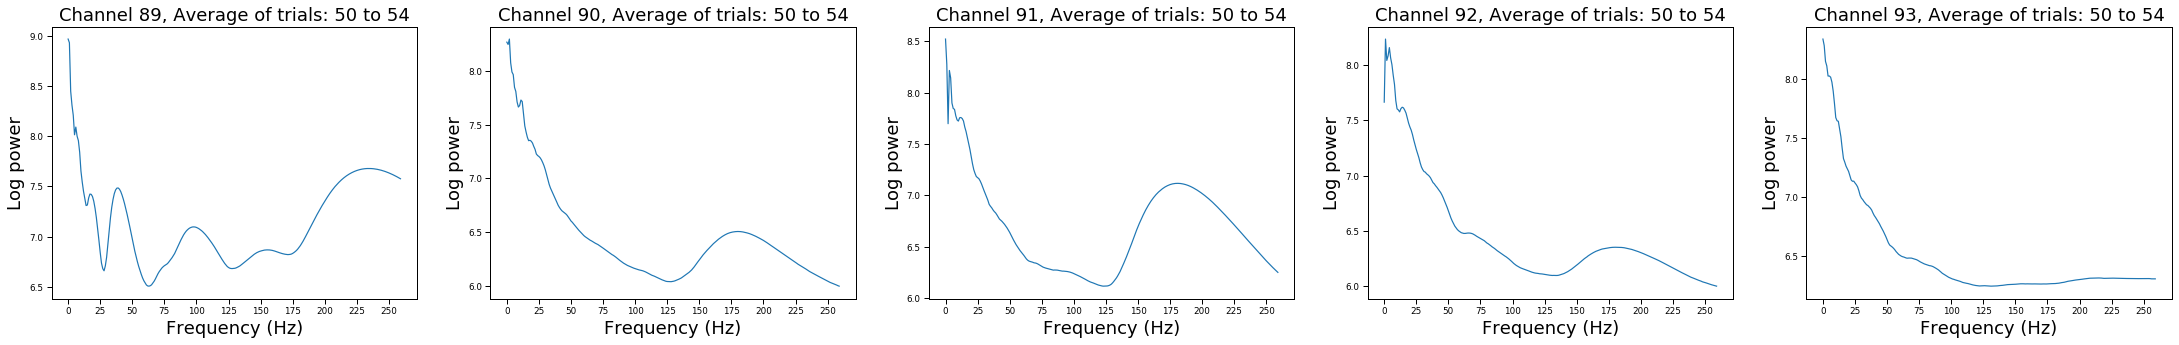

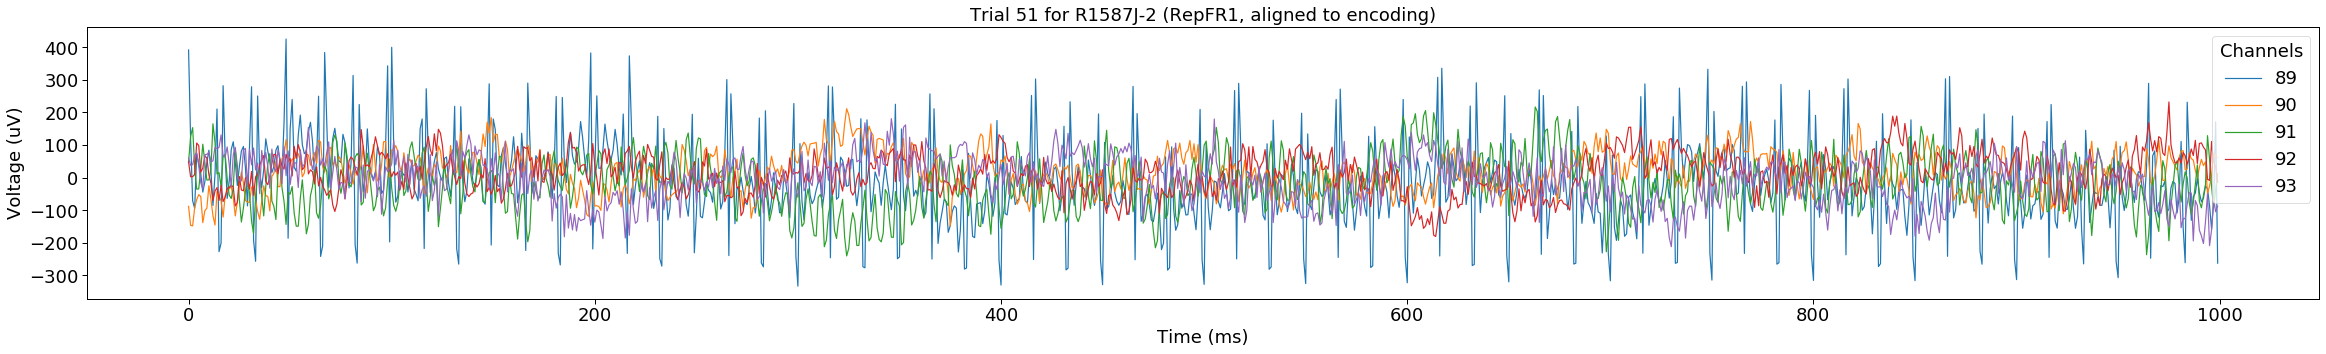

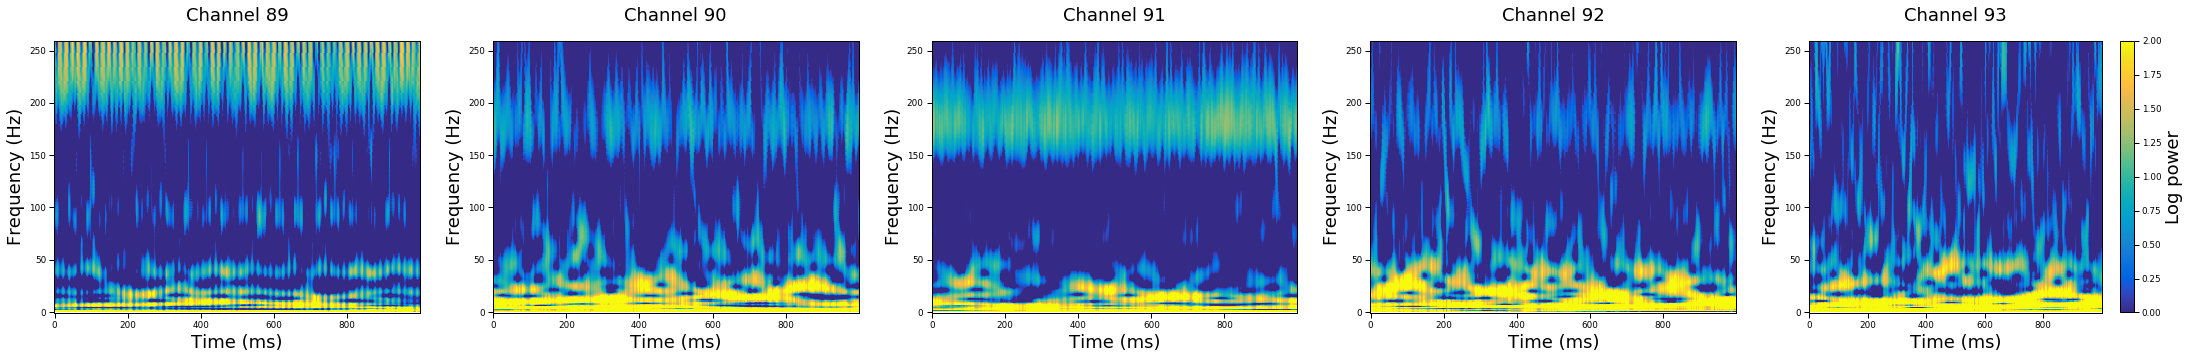

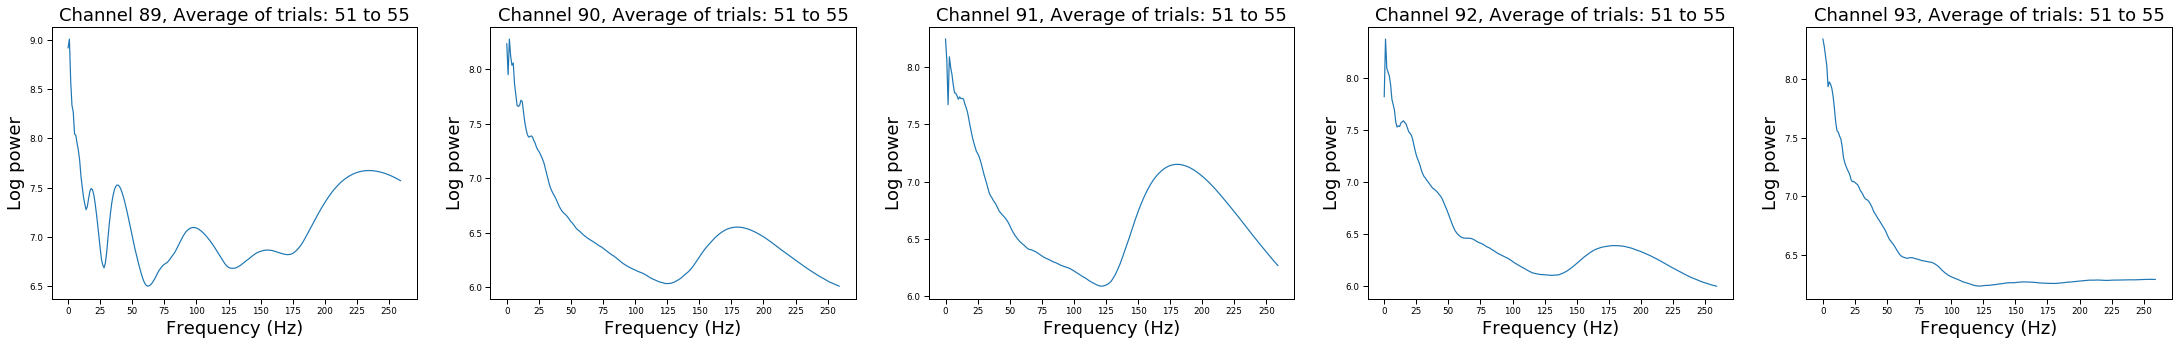

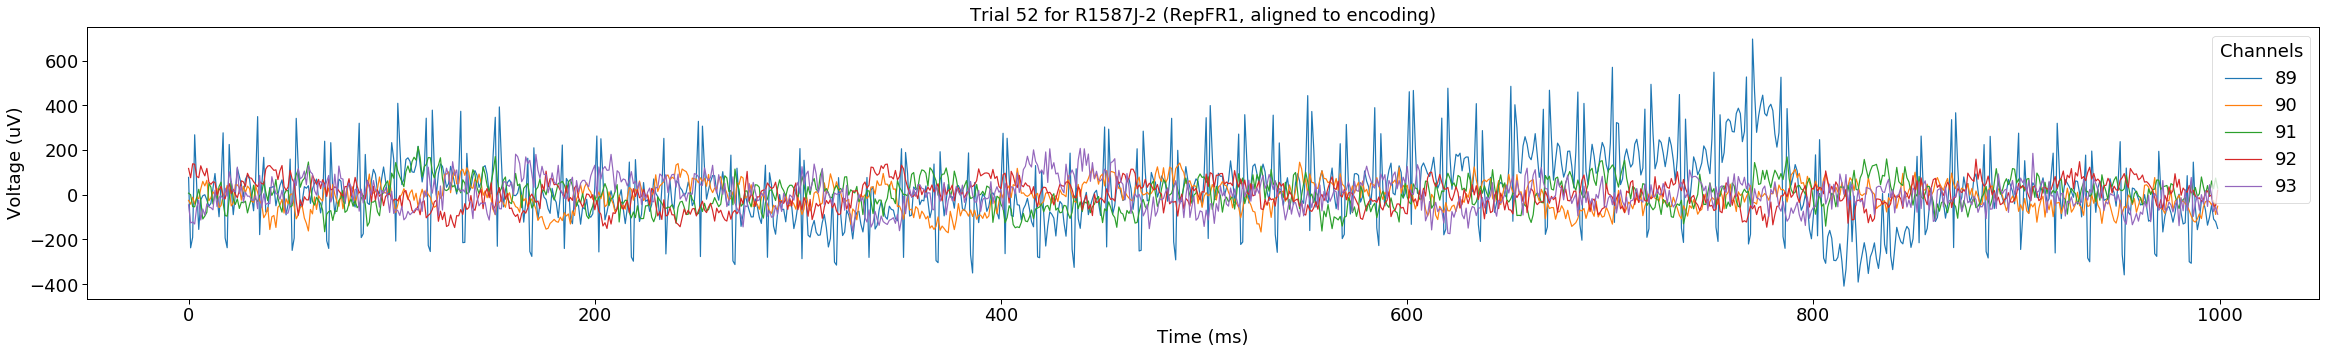

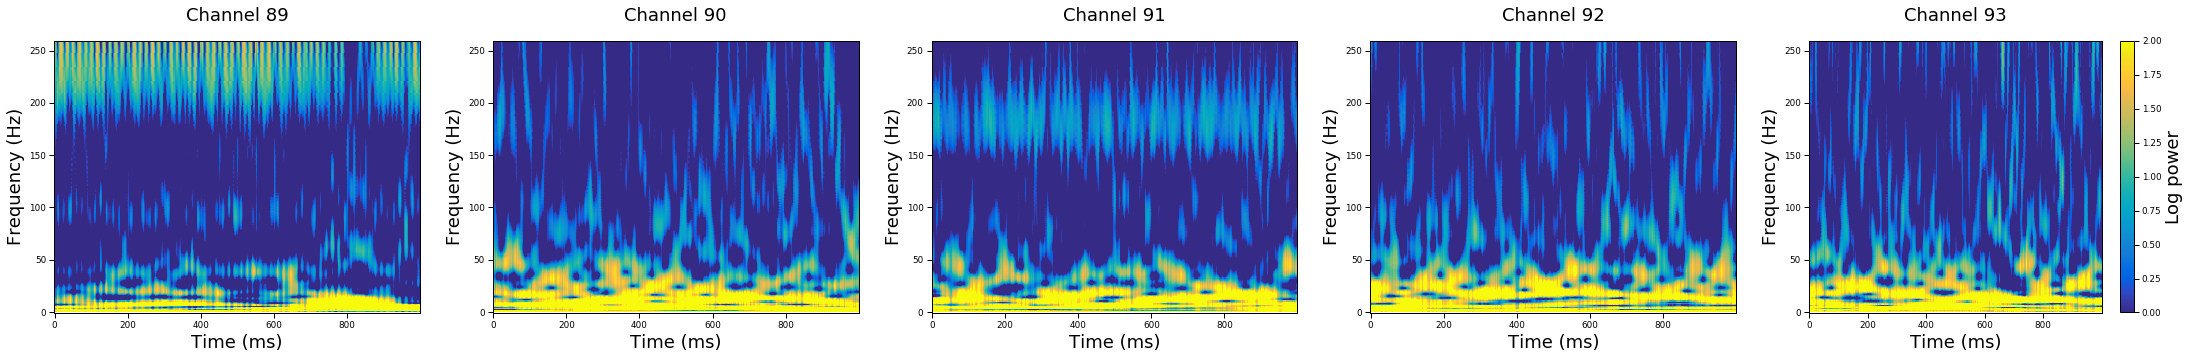

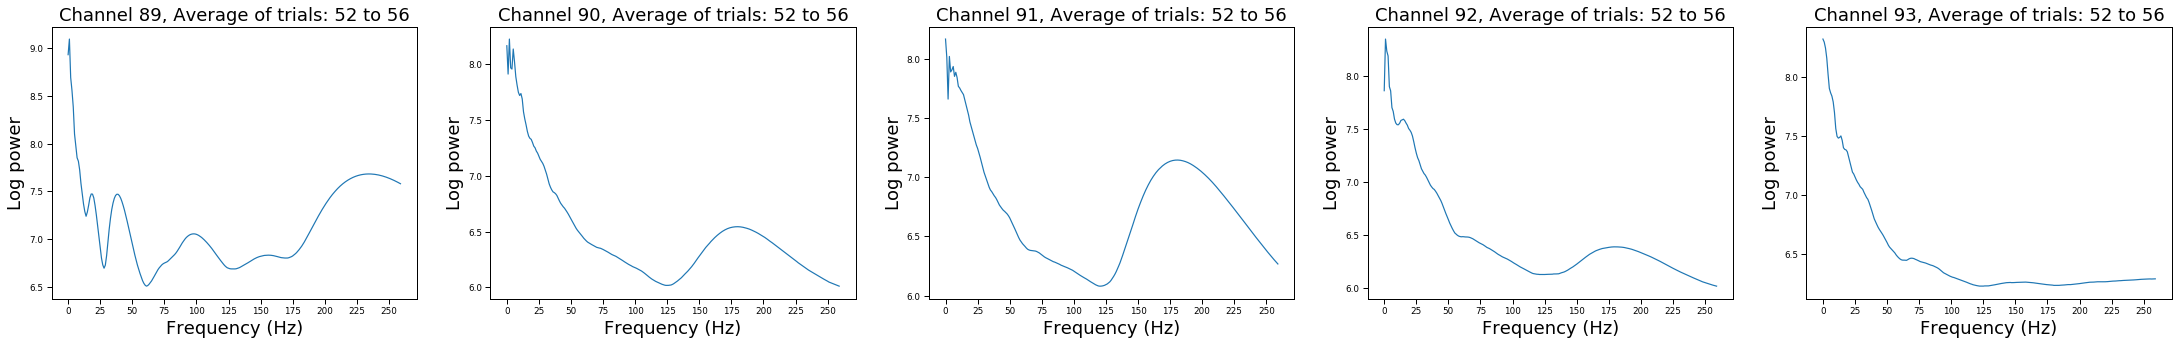

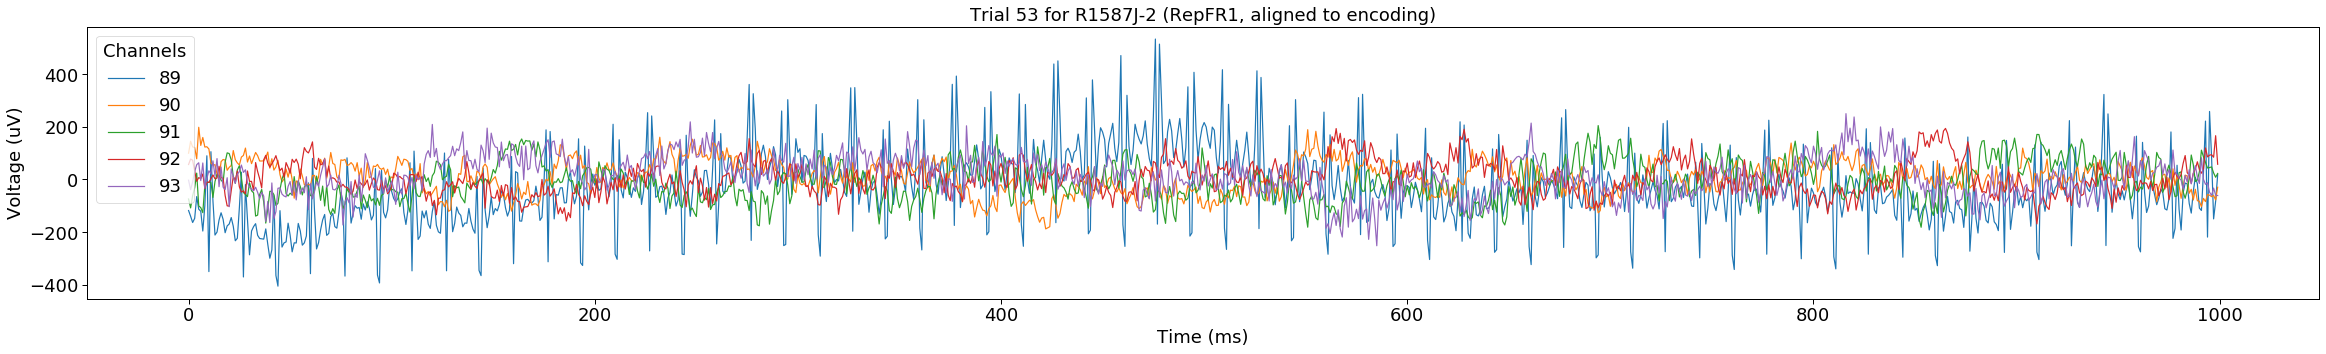

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2b3c16c0c5f0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b3c16e94e60> (for post_execute):


KeyboardInterrupt: 

In [250]:
from scipy import stats
from general import parula_map
import seaborn as sb
sb.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18,
                            "axes.ticksize":18,"axes.titlesize":18})

trial_range = np.arange(50,55)
elec_range = range(89,94)

freq_range = np.arange(1,260.1,1)
time_chunk = 1000 # ms
num_to_avg_for_psd = 5

sr = line_filt_dat.samplerate.values

for tr in trial_range:
    plt.subplots(1,1,figsize=(40,5))     
    plt.plot(np.swapaxes(line_filt_dat[tr,elec_range,range( int(buf/1000*sr),int((time_chunk+buf)/1000*sr) )].values,1,0))
    plt.legend(elec_range,title='Channels',prop={"size":18})
#     plt.ylim(-200,200)   
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (uV)')
    plt.xticks(FontSize=18); plt.yticks(FontSize=18)
    plt.title('Trial '+str(tr)+' for '+df_sess['subject']+'-'+str(df_sess['session'])+' ('+exp+', '+'aligned to '+period+')')
    plt.show()
    
    # plot spectrograms
    plt_ct = 0
    plt.subplots(1,5,figsize=(38,5))
    temp_avg_pows = [] # save these for next row of plots below
    for elec in elec_range:
        plt_ct+=1
        temp_ptsa = line_filt_dat[:,elec,:]
        pow_wavelet = MorletWaveletFilter(freqs=freq_range, width=5, output='power',verbose=False)\
            .filter(timeseries=temp_ptsa) # width is num_cycles 
        pows = pow_wavelet.data[:, :, int((buf/1000.)*sr):int((time_chunk+buf)/1000.*sr)]
        pows = np.log10(pows) # freqs X evs X elecs X time

        temp_avg_pows.append(np.mean(np.mean(pows[:,tr:tr+num_to_avg_for_psd,:],2),1))
        
        # make spectrogram
        plt.subplot(1,5,plt_ct)
        plt.matshow(stats.zscore(pows[:, tr, :],0), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=2); 
        plt.title('Channel '+str(elec))
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (ms)')
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_ticks_position('bottom')        
        if plt_ct==5:
            cbar = plt.colorbar()
            cbar.set_label('Log power')
    plt.show()
    
    
    # plot PSDs    
    plt_ct = 0
    plt.subplots(1,5,figsize=(38,5))
    for elec in elec_range:
        plt_ct+=1
        avg_pows = temp_avg_pows[plt_ct-1]
        plt.subplot(1,5,plt_ct)
        plt.plot(avg_pows)  
        plt.title('Channel '+str(elec)+', Average of trials: '+str(tr)+' to '+str(tr+num_to_avg_for_psd-1))
        plt.ylabel('Log power')
        plt.xlabel('Frequency (Hz)') 
        plt.xticks(np.arange(0,250.1,25))
#         plt.ylim(0,10)
    plt.show()
    
a=1;

In [509]:
np.shape(z_pow_all)
np.shape(z_pow_stacked)
np.shape(dat)
FREQS

(540, 98, 8)

(540, 784)

(8, 540, 98)

array([  3.        ,   5.38446876,   9.66416796,  17.34547017,
        31.13204744,  55.87651233, 100.28844509, 180.        ])

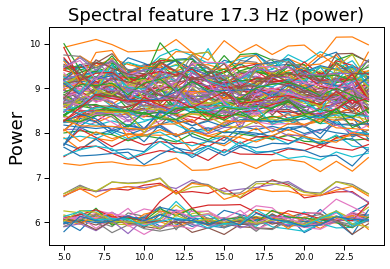

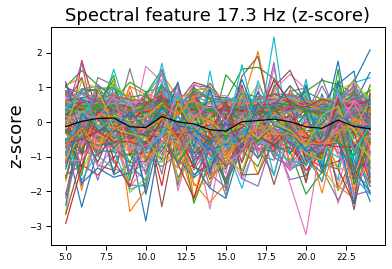

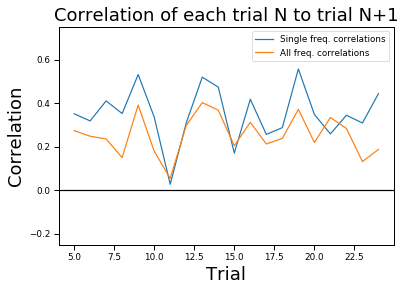

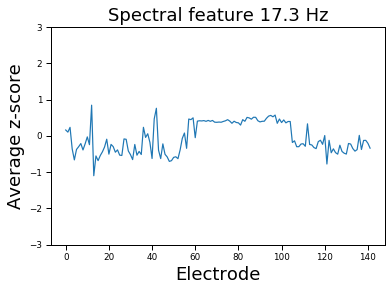

In [25]:
freq = 3
trial_range = np.arange(5,25) # (335,350) # (135,150) # from z_pow_all so all 540 for session (multiply 4.5 to scale to 2d RSA plots)

plt.plot(trial_range,dat[freq,trial_range,:]); 
plt.ylabel('Power')
plt.title('Spectral feature '+str(np.round(FREQS[freq],1))+' Hz (power)')
plt.show()

z_pow_all = xr.apply_ufunc(sp.stats.zscore, dat, 
                           input_core_dims=[['channel', 'frequency']], 
                           output_core_dims=[['channel', 'frequency']]) # outputs trials x elecs x 8
np.shape(z_pow_all)
plt.plot(trial_range,z_pow_all[trial_range,:,freq]);
plt.plot(trial_range,np.mean(z_pow_all[trial_range,:,freq],1),color=(0,0,0))
plt.title('Spectral feature '+str(np.round(FREQS[freq],1))+' Hz (z-score)')
plt.ylabel('z-score')
plt.show()

# plot correlations of trial N to N+1
np.shape(z_pow_all)
np.shape(z_pow_stacked)
freq_corrs = []
all_corrs = []
for tr in trial_range:    
    freq_corrs.append(np.corrcoef(z_pow_all[tr,:,freq],z_pow_all[tr+1,:,freq])[0,1])
    all_corrs.append(np.corrcoef(z_pow_stacked[tr,:],z_pow_stacked[tr+1,:])[0,1])    
plt.plot(trial_range,freq_corrs,label='Single freq. correlations')
plt.plot(trial_range,all_corrs,label='All freq. correlations')
plt.title('Correlation of each trial N to trial N+1')
plt.xlabel('Trial')
plt.ylabel('Correlation')
plt.legend()
plt.axhline(0,color=(0,0,0))
plt.ylim(-0.25,0.75)
plt.show()

# plot z-score by channels
plt.plot(np.mean(z_pow_all[trial_range,:,freq],0))
plt.ylabel('Average z-score')
plt.xlabel('Electrode')
plt.ylim(-3,3)
plt.title('Spectral feature '+str(np.round(FREQS[freq],1))+' Hz')

a=1;